# 모델링
** 사용모델 **  
- Stacked RNN (LSTM) : time length 별 성능 비교

In [2]:
# 주피터 노트북 전체화면 설정
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

# 0. 사용 함수 정의

In [3]:
def rmse(ground_truth, pred) :
    m = mean_squared_error(ground_truth, pred)
    rm = np.sqrt(m)
    
    return rm

def time_feature(df) :
    
    df['time'] = pd.to_datetime(df['time'])
    df['month'] = df['time'].apply(lambda x : x.month)
    df['day'] = df['time'].apply(lambda x : x.day)
    df['hour'] = df['time'].apply(lambda x : x.hour)
    df['minute'] = df['time'].apply(lambda x : x.minute)
    
    return df

def onehot(df_train, df_test, cols) :
    
    for col in cols :
        df_train[col] = df_train[col].apply(lambda x : str(x))
        df_test[col] = df_test[col].apply(lambda x : str(x))
    
    oh = OneHotEncoder()
    
    df_train_oh = oh.fit_transform(df_train[cols])
    df_train_new = np.hstack([df_train['volt'].values.reshape(-1,1), df_train_oh.toarray()])

    df_test_oh = oh.transform(df_test[cols])
    df_test_new = np.hstack([df_test['volt'].values.reshape(-1,1), df_test_oh.toarray()])
    
    return df_train_new, df_test_new

def data2seq(df, col, length = 4) :
    
    res = np.zeros((df.shape[0],length))
    init = df.loc[0,col]
    
    for i in range(df.shape[0]) :
        for j in range(length) :
            if (i - j) < 0 :
                res[i,length - 1 - j] = init
            else :
                res[i,length - 1 - j] = df.loc[i-j, col]
            
    return res

# 1. 데이터 전처리

In [4]:
# 필요한 칼럼 추출

data = pd.read_excel('전체 데이터 통합 파일(0624).xlsx', index_col=0)
data.reset_index(inplace = True)

d1 = data[data['투입 후 운전용량'].notnull()][['일시', '모선전압', '투입 후 운전용량']]
d2 = data[data['투입 후 운전용량'].isnull()][['일시', '모선전압', '투입 전 운전용량']]

cols = ['time', 'volt', 'cap']
d1.columns = cols
d2.columns = cols

d12 = pd.concat([d1, d2])
d12.reset_index(drop = True, inplace = True)
d12

,time,volt,cap
0,2019-01-02 08:51:00,351.1,724.1
1,2019-01-02 18:07:00,356.5,845.8
2,2019-01-05 09:21:00,348.9,716.6
3,2019-01-05 09:39:00,349.3,615.0
4,2019-01-05 18:43:00,355.7,829.7
...,...,...,...
451323,2021-01-18 10:00:00,348.2,507.0
451324,2021-01-18 10:02:00,348.0,506.9
451325,2021-01-18 10:03:00,348.0,506.9
451326,2021-01-18 10:04:00,348.0,506.6


In [5]:
# 이상치가 존재하는 행 제거

ind = d12[d12['volt'] < 340].index

d12.drop(ind, axis = 0, inplace = True)
d12.reset_index(drop = True, inplace = True)

# 2. 모델링
## (1) 모델링

In [13]:
# lengths 정의
lengths = [1, 2, 3, 5, 6, 7, 8, 9, 10]

# 결과 저장 배열 정의
res = np.zeros((2, len(lengths)))

In [33]:
y = d12['cap'].values

cnt = 0
for length in lengths :
    
    seq_v = data2seq(d12, 'volt', length)
    seq_c = data2seq(d12, 'cap', length + 1)
    
    seq_c = np.delete(seq_c, -1, 1)
    
    seq_v = (seq_v - seq_v.min()) / (seq_v.max() - seq_v.min())
    seq_c = (seq_c - seq_c.min()) / (seq_c.max() - seq_c.min())
    
    X = np.zeros((d12.shape[0], length, 2))
    
    X[:, :, 0] = seq_v
    X[:, :, 1] = seq_c
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42)
    
    model = keras.Sequential()
    model.add(keras.layers.LSTM(128,  input_shape = (length, 2), return_sequences = True))
    model.add(keras.layers.LSTM(128, return_sequences = False))
    model.add(keras.layers.Dense(1))

    model.compile(loss = 'mse', optimizer='adam')

    callbacks = [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)]

    model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 2000, batch_size = 14, callbacks = callbacks, verbose = 0)
    
    pred = model.predict(X_test)

    score = rmse(y_test, pred)
    
    print(cnt, length, score)
    
    res[0, cnt] = length
    res[1, cnt] = score
    
    cnt += 1


res

array([[ 1.        ,  2.        ,  3.        ,  5.        ,  6.        ,
         7.        ,  8.        ,  9.        , 10.        ],
       [20.53264388, 14.12582721, 13.32949117, 12.84186647, 12.87774582,
        12.78632252, 13.40259812, 13.26840828, 12.88246335]])

In [57]:
res = np.hstack([res,[[4],[12.86]]])
res_sorted = res[:,res[0].argsort()]
res_sorted

array([[ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        , 10.        ],
       [20.53264388, 14.12582721, 13.32949117, 12.86      , 12.84186647,
        12.87774582, 12.78632252, 13.40259812, 13.26840828, 12.88246335]])

## (2) DataFrame

In [59]:
res_df = pd.DataFrame({'Length' : res_sorted[0,:], 'RMSE' : res_sorted[1,:]})

res_df

,Length,RMSE
0,1.0,20.532644
1,2.0,14.125827
2,3.0,13.329491
3,4.0,12.860000
4,5.0,12.841866
5,6.0,12.877746
6,7.0,12.786323
7,8.0,13.402598
8,9.0,13.268408
9,10.0,12.882463


## (3) Plot

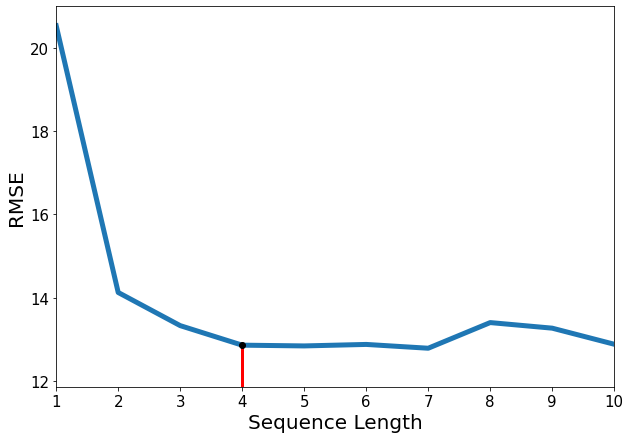

In [99]:
plt.figure(figsize = (10, 7))
plt.plot(res_df.iloc[:,0], res_df.iloc[:,1],  linewidth = 5)
plt.xlabel('Sequence Length', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.plot(4, 12.86, 'ko')
plt.vlines(x = 4, ymin = 11.86, ymax = 12.86, color = 'r', linewidth = 3)
plt.axis([1,10,11.86,21])

# plt.savefig('fig1.png')